In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [3]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vz'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vz'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [4]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


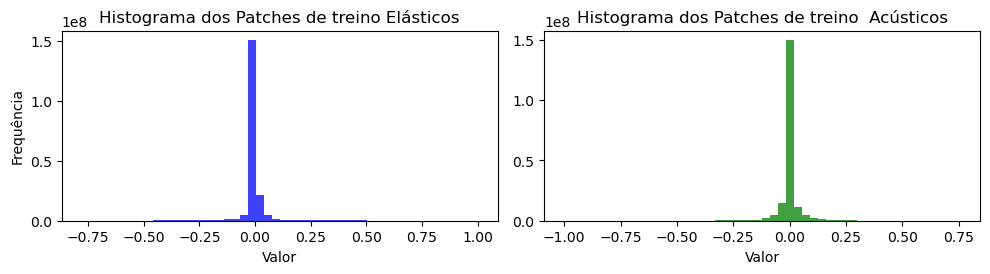

In [5]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

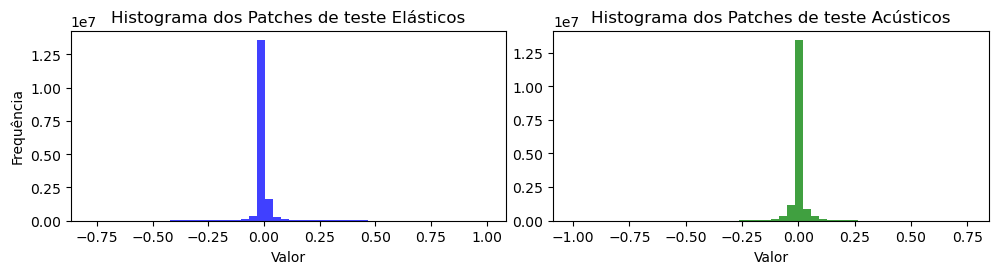

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

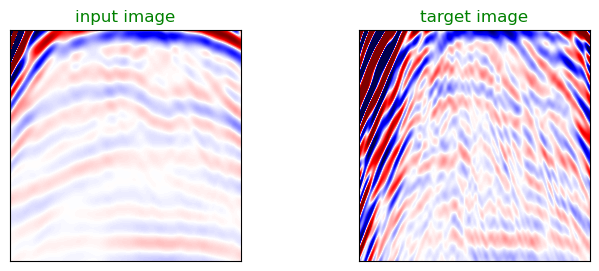

In [7]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("target image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

In [8]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False, apply_dropout=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, kernel_size=4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True, apply_dropout=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

In [10]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() 
#criterion_GAN = nn.MSELoss()

In [11]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [12]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [13]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


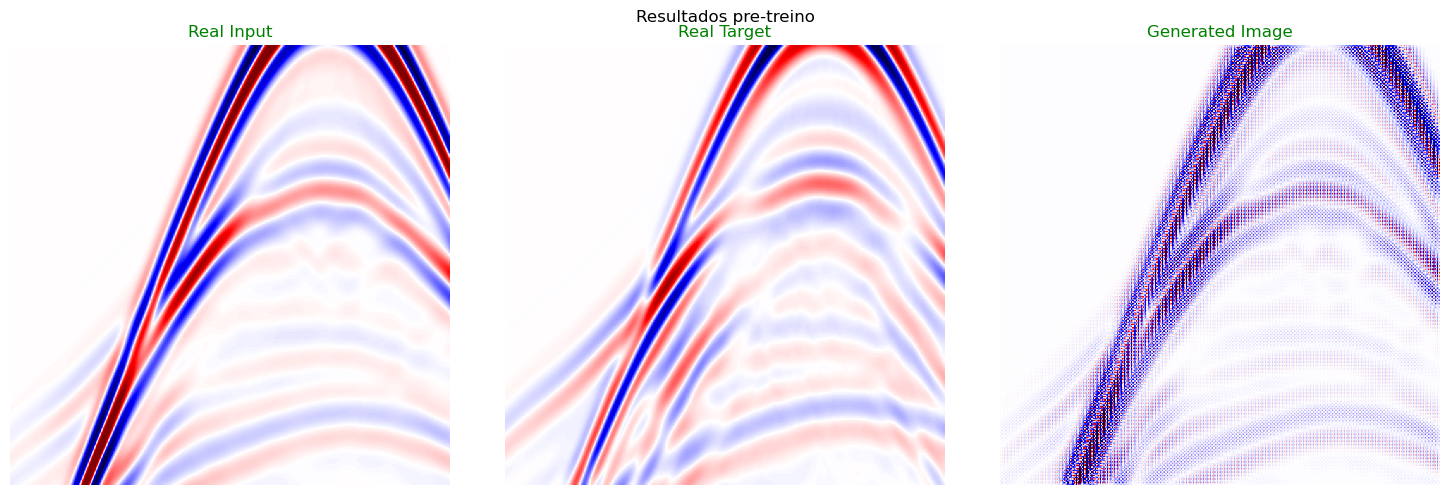

In [14]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [15]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [16]:
n_epoches = 120
# decay_epoch = 100 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

# lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
# lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com basse na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        #if it % 2 == 0:
        
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()
    
    # lr_scheduler_G.step()
    # lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 1/120]
[G loss: 9.141616821289062 | GAN: 1.0427287817001343 L1: 0.008098888210952282]
[D loss: 0.2921358048915863]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 2/120]
[G loss: 12.519575119018555 | GAN: 2.9961166381835938 L1: 0.009523458778858185]
[D loss: 0.6012106537818909]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 3/120]
[G loss: 10.222541809082031 | GAN: 2.7388663291931152 L1: 0.007483676075935364]
[D loss: 0.34383100271224976]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 4/120]
[G loss: 7.494132041931152 | GAN: 4.213235378265381 L1: 0.003280896693468094]
[D loss: 0.025522330775856972]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 5/120]
[G loss: 11.434706687927246 | GAN: 6.888844013214111 L1: 0.004545862786471844]
[D loss: 0.0018238035263493657]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 6/120]
[G loss: 13.28816032409668 | GAN: 6.584265232086182 L1: 0.006703895516693592]
[D loss: 0.0049703228287398815]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 7/120]
[G loss: 8.94200325012207 | GAN: 6.453174591064453 L1: 0.00248882919549942]
[D loss: 0.003286929801106453]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 8/120]
[G loss: 13.482423782348633 | GAN: 8.024568557739258 L1: 0.005457855761051178]
[D loss: 0.010632430203258991]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 9/120]
[G loss: 9.63186264038086 | GAN: 7.365172386169434 L1: 0.0022666901350021362]
[D loss: 0.0015576917212456465]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 10/120]
[G loss: 8.473525047302246 | GAN: 6.009416580200195 L1: 0.002464108634740114]
[D loss: 0.005367175675928593]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.25it/s]


[Epoch 11/120]
[G loss: 13.604305267333984 | GAN: 9.823410987854004 L1: 0.0037808946799486876]
[D loss: 0.001985402312129736]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 12/120]
[G loss: 9.21133041381836 | GAN: 6.516761302947998 L1: 0.0026945695281028748]
[D loss: 0.003843630664050579]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.26it/s]


[Epoch 13/120]
[G loss: 3.5393972396850586 | GAN: 0.43426311016082764 L1: 0.0031051342375576496]
[D loss: 0.589727520942688]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.28it/s]


[Epoch 14/120]
[G loss: 8.1837158203125 | GAN: 5.750417709350586 L1: 0.002433298621326685]
[D loss: 0.004278217442333698]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 15/120]
[G loss: 8.011816024780273 | GAN: 5.5693793296813965 L1: 0.0024424365255981684]
[D loss: 0.009054443798959255]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 16/120]
[G loss: 6.877867698669434 | GAN: 1.3288614749908447 L1: 0.005549006164073944]
[D loss: 0.652041494846344]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 17/120]
[G loss: 11.11075496673584 | GAN: 7.742167949676514 L1: 0.003368586767464876]
[D loss: 0.0013049582485109568]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.07it/s]


[Epoch 18/120]
[G loss: 3.6144492626190186 | GAN: 0.764740526676178 L1: 0.002849708776921034]
[D loss: 0.5946846008300781]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 19/120]
[G loss: 11.972021102905273 | GAN: 9.438952445983887 L1: 0.0025330684147775173]
[D loss: 0.003577225608751178]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 20/120]
[G loss: 11.465681076049805 | GAN: 9.287485122680664 L1: 0.0021781963296234608]
[D loss: 0.0007537000346928835]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 21/120]
[G loss: 4.9602131843566895 | GAN: 3.4218227863311768 L1: 0.0015383902937173843]
[D loss: 0.05960487946867943]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 22/120]
[G loss: 11.635591506958008 | GAN: 8.065250396728516 L1: 0.003570340573787689]
[D loss: 0.00246640108525753]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 23/120]
[G loss: 2.8821358680725098 | GAN: 0.9488930702209473 L1: 0.0019332428928464651]
[D loss: 0.614250659942627]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 24/120]
[G loss: 9.480316162109375 | GAN: 6.542026042938232 L1: 0.0029382905922830105]
[D loss: 0.0034507769159972668]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 25/120]
[G loss: 12.127086639404297 | GAN: 8.524308204650879 L1: 0.0036027778405696154]
[D loss: 0.017057638615369797]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.39it/s]


[Epoch 26/120]
[G loss: 15.356361389160156 | GAN: 11.504731178283691 L1: 0.0038516302593052387]
[D loss: 0.0008003659313544631]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 27/120]
[G loss: 12.353972434997559 | GAN: 10.283565521240234 L1: 0.0020704069174826145]
[D loss: 0.0005649647209793329]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 28/120]
[G loss: 12.107833862304688 | GAN: 10.621353149414062 L1: 0.0014864809345453978]
[D loss: 0.00013867099187336862]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 29/120]
[G loss: 8.540302276611328 | GAN: 6.20301628112793 L1: 0.0023372857831418514]
[D loss: 0.0031828824430704117]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 30/120]
[G loss: 13.704764366149902 | GAN: 10.107604026794434 L1: 0.003597160568460822]
[D loss: 0.0006850264617241919]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 31/120]
[G loss: 6.663548946380615 | GAN: 5.170087814331055 L1: 0.001493461080826819]
[D loss: 0.016304941847920418]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 32/120]
[G loss: 12.309829711914062 | GAN: 10.42736530303955 L1: 0.0018824641592800617]
[D loss: 0.00033156725112348795]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 33/120]
[G loss: 11.40730094909668 | GAN: 8.403654098510742 L1: 0.0030036463867872953]
[D loss: 0.0007105731638148427]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 34/120]
[G loss: 10.814929962158203 | GAN: 7.795160293579102 L1: 0.003019769210368395]
[D loss: 0.021827658638358116]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 35/120]
[G loss: 9.684948921203613 | GAN: 8.232834815979004 L1: 0.0014521144330501556]
[D loss: 0.0005250161630101502]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 36/120]
[G loss: 3.22682523727417 | GAN: 1.2989318370819092 L1: 0.0019278934923931956]
[D loss: 0.7763707637786865]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 37/120]
[G loss: 6.984903812408447 | GAN: 5.320458889007568 L1: 0.0016644449206069112]
[D loss: 0.004412539303302765]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 38/120]
[G loss: 10.269376754760742 | GAN: 8.567413330078125 L1: 0.0017019633669406176]
[D loss: 0.0009425839525647461]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.25it/s]


[Epoch 39/120]
[G loss: 14.388494491577148 | GAN: 11.610078811645508 L1: 0.0027784151025116444]
[D loss: 7.86212767707184e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 40/120]
[G loss: 9.683992385864258 | GAN: 7.374804973602295 L1: 0.0023091870825737715]
[D loss: 0.004517375025898218]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 41/120]
[G loss: 11.637791633605957 | GAN: 9.243590354919434 L1: 0.00239420123398304]
[D loss: 0.00016639393288642168]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 42/120]
[G loss: 8.660931587219238 | GAN: 5.686887264251709 L1: 0.002974044531583786]
[D loss: 0.0039168959483504295]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 43/120]
[G loss: 11.561131477355957 | GAN: 8.886757850646973 L1: 0.002674373798072338]
[D loss: 0.000476801855256781]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 44/120]
[G loss: 11.379345893859863 | GAN: 8.811708450317383 L1: 0.002567637711763382]
[D loss: 0.0008386573754251003]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 45/120]
[G loss: 12.249475479125977 | GAN: 10.081968307495117 L1: 0.002167507540434599]
[D loss: 0.0004847643431276083]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 46/120]
[G loss: 10.062397956848145 | GAN: 7.36756706237793 L1: 0.0026948307640850544]
[D loss: 0.0008297321619465947]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 47/120]
[G loss: 13.91239070892334 | GAN: 11.50738525390625 L1: 0.0024050052743405104]
[D loss: 0.0001287840132135898]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 48/120]
[G loss: 6.089856147766113 | GAN: 4.59647798538208 L1: 0.0014933780767023563]
[D loss: 0.013068228960037231]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.28it/s]


[Epoch 49/120]
[G loss: 11.30886459350586 | GAN: 8.91985034942627 L1: 0.0023890137672424316]
[D loss: 0.00046759817632846534]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 50/120]
[G loss: 11.135554313659668 | GAN: 7.98764705657959 L1: 0.0031479070894420147]
[D loss: 0.0025064877700060606]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 51/120]
[G loss: 13.334234237670898 | GAN: 11.0458984375 L1: 0.002288335468620062]
[D loss: 0.0006627759430557489]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 52/120]
[G loss: 9.943947792053223 | GAN: 7.4906392097473145 L1: 0.0024533087853342295]
[D loss: 0.0016184377018362284]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 53/120]
[G loss: 13.398605346679688 | GAN: 10.845088005065918 L1: 0.0025535172317177057]
[D loss: 0.0001001318814815022]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 54/120]
[G loss: 18.616172790527344 | GAN: 13.376608848571777 L1: 0.005239563528448343]
[D loss: 8.672024705447257e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 55/120]
[G loss: 12.160849571228027 | GAN: 9.703727722167969 L1: 0.002457121852785349]
[D loss: 0.00010819533781614155]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.27it/s]


[Epoch 56/120]
[G loss: 17.081161499023438 | GAN: 13.206925392150879 L1: 0.003874235786497593]
[D loss: 1.4827461200184189e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 57/120]
[G loss: 3.9904325008392334 | GAN: 2.411972761154175 L1: 0.0015784597489982843]
[D loss: 0.3636138439178467]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 58/120]
[G loss: 10.419757843017578 | GAN: 8.640314102172852 L1: 0.0017794438172131777]
[D loss: 0.00040207477286458015]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 59/120]
[G loss: 13.415881156921387 | GAN: 11.844198226928711 L1: 0.0015716829802840948]
[D loss: 0.00012055916886311024]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 60/120]
[G loss: 2.4980573654174805 | GAN: 0.7742111682891846 L1: 0.0017238461878150702]
[D loss: 0.6345742344856262]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 61/120]
[G loss: 5.680352210998535 | GAN: 3.5784289836883545 L1: 0.0021019228734076023]
[D loss: 0.022878551855683327]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.07it/s]


[Epoch 62/120]
[G loss: 10.515469551086426 | GAN: 8.49539566040039 L1: 0.002020073588937521]
[D loss: 0.0012337994994595647]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 63/120]
[G loss: 10.519562721252441 | GAN: 8.369253158569336 L1: 0.002150309272110462]
[D loss: 0.000697326147928834]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 64/120]
[G loss: 9.70736312866211 | GAN: 7.833072185516357 L1: 0.001874290406703949]
[D loss: 0.0013538742205128074]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 65/120]
[G loss: 9.796475410461426 | GAN: 6.80051851272583 L1: 0.0029959569219499826]
[D loss: 0.0011398368515074253]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 66/120]
[G loss: 9.965855598449707 | GAN: 8.541624069213867 L1: 0.001424231450073421]
[D loss: 0.00043243670370429754]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 67/120]
[G loss: 10.129209518432617 | GAN: 8.421833038330078 L1: 0.0017073762137442827]
[D loss: 0.0009597997996024787]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 68/120]
[G loss: 10.425158500671387 | GAN: 7.976327419281006 L1: 0.002448831219226122]
[D loss: 0.0007383025949820876]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.32it/s]


[Epoch 69/120]
[G loss: 9.290984153747559 | GAN: 8.161945343017578 L1: 0.0011290386319160461]
[D loss: 0.004001351539045572]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 70/120]
[G loss: 13.121821403503418 | GAN: 9.652669906616211 L1: 0.003469151444733143]
[D loss: 0.00040009833173826337]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 71/120]
[G loss: 11.87399673461914 | GAN: 9.654972076416016 L1: 0.002219025045633316]
[D loss: 0.00014426224515773356]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 72/120]
[G loss: 12.133530616760254 | GAN: 8.823238372802734 L1: 0.0033102924935519695]
[D loss: 0.0008965857559815049]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 73/120]
[G loss: 13.865848541259766 | GAN: 10.85716724395752 L1: 0.003008680883795023]
[D loss: 0.00036151084350422025]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 74/120]
[G loss: 14.480975151062012 | GAN: 12.341936111450195 L1: 0.0021390393376350403]
[D loss: 4.0532122511649504e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 75/120]
[G loss: 14.926983833312988 | GAN: 13.209388732910156 L1: 0.0017175946850329638]
[D loss: 1.7516285879537463e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 76/120]
[G loss: 13.832331657409668 | GAN: 10.157336235046387 L1: 0.0036749951541423798]
[D loss: 7.134185580071062e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 77/120]
[G loss: 3.6418707370758057 | GAN: 1.4082794189453125 L1: 0.0022335913963615894]
[D loss: 1.7511347532272339]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 78/120]
[G loss: 11.328474044799805 | GAN: 8.488513946533203 L1: 0.0028399601578712463]
[D loss: 0.0005203036707825959]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 79/120]
[G loss: 8.216176986694336 | GAN: 5.372997283935547 L1: 0.002843179740011692]
[D loss: 0.05656559392809868]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 80/120]
[G loss: 11.167858123779297 | GAN: 8.701412200927734 L1: 0.002466446254402399]
[D loss: 0.0004727431805804372]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 81/120]
[G loss: 9.34961223602295 | GAN: 6.69511079788208 L1: 0.002654501236975193]
[D loss: 0.0027074471581727266]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 82/120]
[G loss: 10.616520881652832 | GAN: 8.983488082885742 L1: 0.0016330326907336712]
[D loss: 0.00045637524453923106]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 83/120]
[G loss: 13.992156028747559 | GAN: 11.209105491638184 L1: 0.0027830502949655056]
[D loss: 0.0002399505174253136]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 84/120]
[G loss: 10.503565788269043 | GAN: 8.565642356872559 L1: 0.0019379237201064825]
[D loss: 0.0002466637233737856]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 85/120]
[G loss: 10.845314025878906 | GAN: 9.296296119689941 L1: 0.0015490177320316434]
[D loss: 0.0007513051968999207]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 86/120]
[G loss: 15.127699851989746 | GAN: 12.435269355773926 L1: 0.002692430280148983]
[D loss: 0.00030119562870822847]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 87/120]
[G loss: 3.439815044403076 | GAN: 1.5735193490982056 L1: 0.0018662958173081279]
[D loss: 0.5195368528366089]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 88/120]
[G loss: 8.618005752563477 | GAN: 6.5378594398498535 L1: 0.002080146688967943]
[D loss: 0.0024440528359264135]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 89/120]
[G loss: 9.664859771728516 | GAN: 7.165380001068115 L1: 0.00249948026612401]
[D loss: 0.001258991309441626]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 90/120]
[G loss: 13.732938766479492 | GAN: 11.922921180725098 L1: 0.001810017740353942]
[D loss: 5.317922114045359e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 91/120]
[G loss: 14.348367691040039 | GAN: 11.91142463684082 L1: 0.0024369433522224426]
[D loss: 2.6477942810743116e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 92/120]
[G loss: 9.183332443237305 | GAN: 7.778007984161377 L1: 0.0014053243212401867]
[D loss: 0.0006436209077946842]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 93/120]
[G loss: 17.187671661376953 | GAN: 13.90648365020752 L1: 0.0032811881974339485]
[D loss: 0.0001822639023885131]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 94/120]
[G loss: 10.91971206665039 | GAN: 7.15462589263916 L1: 0.0037650864105671644]
[D loss: 0.0018419651314616203]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 95/120]
[G loss: 10.57452392578125 | GAN: 6.800422191619873 L1: 0.0037741016130894423]
[D loss: 0.006455652415752411]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 96/120]
[G loss: 11.742162704467773 | GAN: 8.670698165893555 L1: 0.0030714645981788635]
[D loss: 0.0013235403457656503]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 97/120]
[G loss: 17.768522262573242 | GAN: 14.886784553527832 L1: 0.002881737193092704]
[D loss: 0.0003624583187047392]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 98/120]
[G loss: 11.884980201721191 | GAN: 8.552517890930176 L1: 0.003332462627440691]
[D loss: 0.0003019082359969616]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 99/120]
[G loss: 8.91905689239502 | GAN: 6.238839149475098 L1: 0.0026802176143974066]
[D loss: 0.0023624540772289038]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 100/120]
[G loss: 11.740220069885254 | GAN: 8.605070114135742 L1: 0.003135150298476219]
[D loss: 0.0003534547286108136]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 101/120]
[G loss: 11.563974380493164 | GAN: 8.654455184936523 L1: 0.002909518778324127]
[D loss: 0.000237354077398777]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 102/120]
[G loss: 12.235732078552246 | GAN: 10.070940017700195 L1: 0.002164792036637664]
[D loss: 0.00011137995170429349]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.25it/s]


[Epoch 103/120]
[G loss: 8.362070083618164 | GAN: 6.777365684509277 L1: 0.0015847044996917248]
[D loss: 0.0011778607731685042]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 104/120]
[G loss: 9.186601638793945 | GAN: 8.040936470031738 L1: 0.0011456653010100126]
[D loss: 0.0007235651137307286]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 105/120]
[G loss: 11.630237579345703 | GAN: 7.833281517028809 L1: 0.003796956269070506]
[D loss: 0.00035059938090853393]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 106/120]
[G loss: 13.593862533569336 | GAN: 10.055286407470703 L1: 0.0035385764203965664]
[D loss: 5.384220276027918e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 107/120]
[G loss: 6.384178161621094 | GAN: 3.6255314350128174 L1: 0.002758646383881569]
[D loss: 0.10402754694223404]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 108/120]
[G loss: 10.083592414855957 | GAN: 7.91518497467041 L1: 0.002168407430872321]
[D loss: 0.00129737239331007]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 109/120]
[G loss: 12.163138389587402 | GAN: 9.179466247558594 L1: 0.0029836720786988735]
[D loss: 0.0007987249991856515]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 110/120]
[G loss: 13.172405242919922 | GAN: 11.131495475769043 L1: 0.0020409096032381058]
[D loss: 7.486642425647005e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 111/120]
[G loss: 11.781132698059082 | GAN: 9.050196647644043 L1: 0.0027309360448271036]
[D loss: 0.0002330110437469557]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 112/120]
[G loss: 6.733971118927002 | GAN: 6.0787434577941895 L1: 0.0006552276900038123]
[D loss: 0.0066447993740439415]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 113/120]
[G loss: 14.01984977722168 | GAN: 10.799179077148438 L1: 0.0032206708565354347]
[D loss: 0.0003631367872003466]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.26it/s]


[Epoch 114/120]
[G loss: 5.785329341888428 | GAN: 2.6769802570343018 L1: 0.0031083491630852222]
[D loss: 0.18820883333683014]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 115/120]
[G loss: 15.558944702148438 | GAN: 11.98055362701416 L1: 0.0035783913917839527]
[D loss: 0.00017243361799046397]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 116/120]
[G loss: 8.280559539794922 | GAN: 5.647755146026611 L1: 0.0026328046806156635]
[D loss: 0.0042242626659572124]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.25it/s]


[Epoch 117/120]
[G loss: 12.398929595947266 | GAN: 10.316740989685059 L1: 0.002082188380882144]
[D loss: 0.0004717805713880807]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 118/120]
[G loss: 11.029278755187988 | GAN: 8.172652244567871 L1: 0.0028566261753439903]
[D loss: 0.0003592243301682174]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 119/120]
[G loss: 9.013017654418945 | GAN: 7.614631175994873 L1: 0.001398386899381876]
[D loss: 0.0008020391105674207]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 120/120]
[G loss: 10.937149047851562 | GAN: 9.156749725341797 L1: 0.0017803995870053768]
[D loss: 0.00010499874770175666]


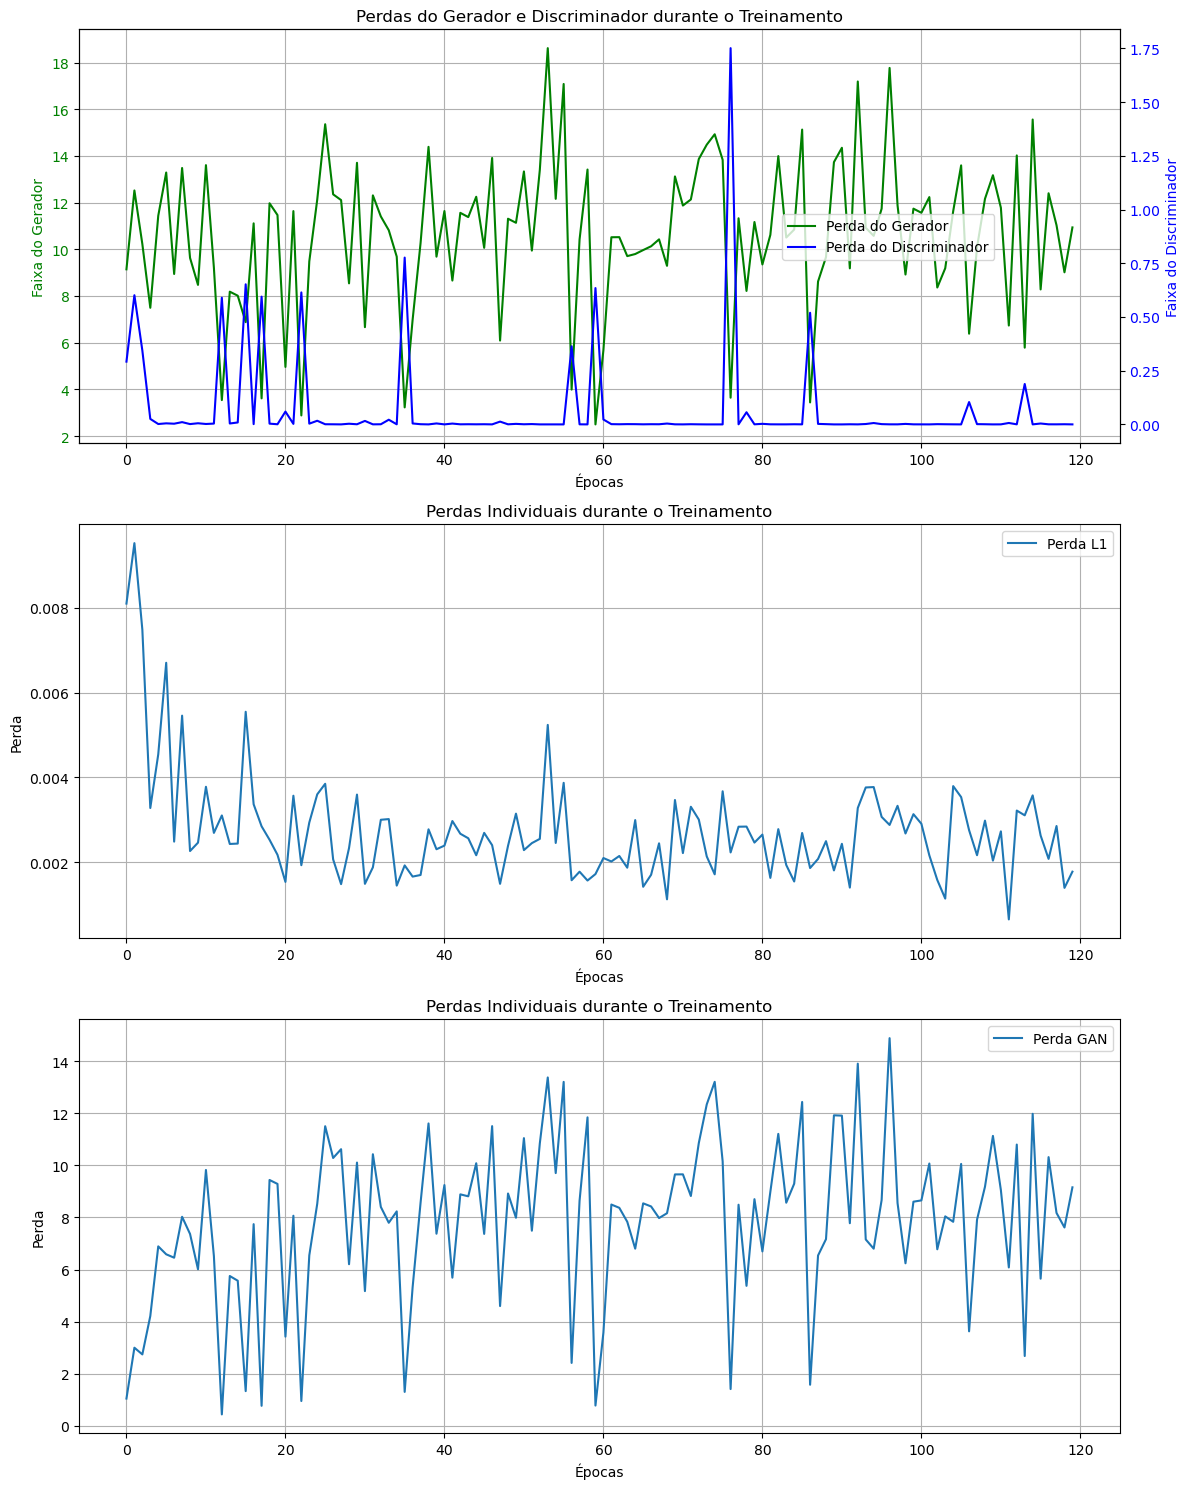

In [17]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VZ_Loss_V2.png')
plt.show()

In [18]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VZcheckpoint_V2.pth')

checkpoint = torch.load('pix2pix_P2VZcheckpoint_V2.pth', weights_only=True)